# Import packages

In [1]:
!pip install pandas
!pip install scikit_learn
!pip install seaborn
!pip install joblib
!pip install matplotlib
!pip install numpy
!pip install ast
!pip install imbalanced-learn
!pip install lightgbm
!pip install random

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 209.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 781.0 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 20.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 7.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 8.8 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 269.9 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Importing packages
import os
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import random

# machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# visualisation
import matplotlib.pyplot as plt
from joblib import dump

# Loading in the data

In [159]:
genderize_emotions = pd.read_csv("/work/VNV/Module 4 - Prediction/data/genderize_14_emotions_dataset.csv")
genderize_emotions_by_character = pd.read_csv("/work/VNV/Module 4 - Prediction/data/emotions_by_character.csv")

In [160]:
# Make a subset for testing
#genderize_emotions = genderize_emotions[:100]

### Preparing the data

In [161]:
# Making the vectors for the emotions by characters
# List of basic emotion columns in the order we want the vector
basic_emotions_columns = [
    "sadness", "joy", "love", "anger", "fear", "surprise"
]
# List of all emotions
all_emotions_columns = [
    "sadness", "joy", "love", "anger", "fear", "surprise",
    "guilt", "despair", "disapproval", "envy", "delight",
    "pride", "outrage", "awe"
]

# Create a new column basic_emotions_vector with a list of emotion values per row
genderize_emotions_by_character["basic_emotions_vector"] = genderize_emotions_by_character[basic_emotions_columns].values.tolist()

# Create a new column all_emotions_vector with a list of emotion values per row
genderize_emotions_by_character["all_emotions_vector"] = genderize_emotions_by_character[all_emotions_columns].values.tolist()

### Make a data frame with the meta-data for later use

In [162]:
# Load in the meta-data
movie_meta_labels = pd.read_csv("/work/VNV/Module 1 - Data acqusition and preparation/output/cornell_all_three_gender_labels.csv")
movie_meta_relase_year = pd.read_csv("/work/VNV/Module 1 - Data acqusition and preparation/data/movie_title_meta_cleaned.csv")

# Clean the columns with "movieID"
movie_meta_labels['movieID'] = movie_meta_labels['movieID'].str.strip()
movie_meta_relase_year['movieID'] = movie_meta_relase_year['movieID'].str.strip()

# Clean the columns with "characterID"
movie_meta_labels['characterID'] = movie_meta_labels['characterID'].str.strip()

In [163]:
# we want to merge "movie_meta_labels" and "movie_meta_relase_year" to get movie character and the release year of the associated movie
movie_meta = pd.merge(
    movie_meta_labels,  # keep all the columns from movie_meta_labels 
    movie_meta_relase_year[['movieID', 'movie_year']],  # Select 'characterID' and 'gender' from movie_characters_original
    on='movieID',  # Merge on 'characterID'
    how='left'  # Use left join to keep all rows from movie_lines
)

# Check that everything looks good
print(movie_meta.head())

# Remove unnecesarry variables
movie_meta = movie_meta[['characterID', 'character_name', 'movie_year', 'gender', 'genderize_gender']]

# Clean the columns for extra spaces
movie_meta['characterID'] = movie_meta['characterID'].str.strip()

# Check that everything looks good
print(movie_meta.head())

  characterID character_name movieID                   movie_title gender  \
0          u0         Bianca      m0   10 things i hate about you       f   
1          u1          Bruce      m0   10 things i hate about you       ?   
2          u2        Cameron      m0   10 things i hate about you       m   
3          u3       Chastity      m0   10 things i hate about you       ?   
4          u4           Joey      m0   10 things i hate about you       m   

  position_in_credits genderize_gender genderguesser_gender  movie_year  
0                   4                f                    f        1999  
1                   ?                m                    m        1999  
2                   3                m                    m        1999  
3                   ?                f                    f        1999  
4                   6                m                    m        1999  
  characterID character_name  movie_year gender genderize_gender
0          u0         Bianca

# Neural network for Genderize dataset

## For basic emotions

Make a test/train split

In [164]:
# Convert string representations of lists to actual lists
genderize_emotions_by_character['basic_emotions_vector'] = genderize_emotions_by_character['basic_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "basic_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions_by_character['basic_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions_by_character['gender']  # Target label

# Split into training and testing sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y) # Stratify the labels so that the representation of women is similar in train and test

print(f"Training set size: {len(X_train_feats)}")
print(f"Testing set size: {len(X_test_feats)}")

Training set size: 4743
Testing set size: 1186


Apply the dataframe

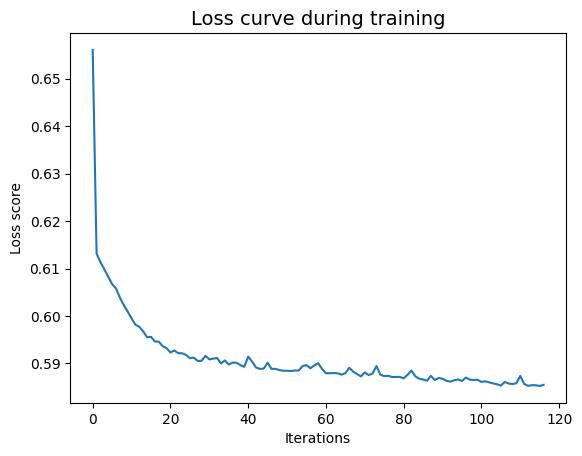

Classification report for the NN basic emotions
              precision    recall  f1-score   support

      female       0.46      0.10      0.16       357
        male       0.71      0.95      0.81       829

    accuracy                           0.69      1186
   macro avg       0.59      0.52      0.49      1186
weighted avg       0.63      0.69      0.62      1186



['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_basic_emotions.joblib']

<Figure size 640x480 with 0 Axes>

In [165]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(100, 50),
    max_iter=3000,
    learning_rate_init=0.001,
    random_state=76)

# Train the classifier
classifier.fit(X_train_feats, y_train) 

# Make predictions on the test set
y_pred = classifier.predict(X_test_feats) 

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_basic_emotions.png")

# Generate and save the classification report
classification_metrics = metrics.classification_report(y_test, y_pred)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_basic_emotions.txt", "w") as f:
    f.write(classification_metrics)

# Print the report
print("Classification report for the NN basic emotions")
print(classification_metrics)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_basic_emotions.joblib")

#### SMOTE (Synthetic Minority Over-sampling Technique)

In [166]:
# Convert string representations of lists to actual lists
genderize_emotions_by_character['basic_emotions_vector'] = genderize_emotions_by_character['basic_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "basic_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions_by_character['basic_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions_by_character['gender']  # Target label

# Split the data into training and test sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=76)
X_train_feats_resampled, y_train_resampled = smote.fit_resample(X_train_feats, y_train)

# Check the class distribution in the resampled data
print(f"Class distribution after SMOTE: {y_train_resampled.value_counts()}")


Class distribution after SMOTE: gender
male      3314
female    3314
Name: count, dtype: int64


Applying the classifier (resampled data: SMOTE)

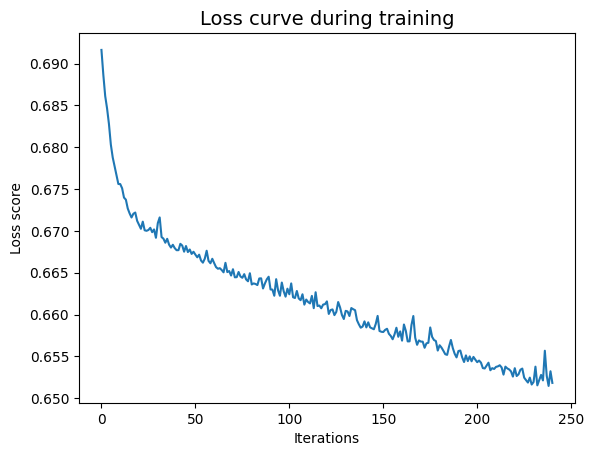

Classification report NN basic emotions (SMOTE):
              precision    recall  f1-score   support

      female       0.38      0.56      0.45       357
        male       0.76      0.60      0.67       829

    accuracy                           0.59      1186
   macro avg       0.57      0.58      0.56      1186
weighted avg       0.65      0.59      0.61      1186



['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_basic_emotions_SMOTE.joblib']

<Figure size 640x480 with 0 Axes>

In [167]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu", # tanh gives 47/63, logistic gives 48/57, relu gives 45/67, identity gives 47/62
    hidden_layer_sizes=(64, 32),
    max_iter=1000,
    learning_rate_init=0.001,
    random_state=76)

# 1. Train on resampled data
classifier.fit(X_train_feats_resampled, y_train_resampled)
y_pred_resampled = classifier.predict(X_test_feats)  # Predict on the test set

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_basic_emotions_SMOTE.png")

# Generate and save classification report for resampled model
classification_metrics_resampled = metrics.classification_report(y_test, y_pred_resampled)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_basic_emotions_SMOTE.txt", "w") as f:
    f.write(classification_metrics_resampled)

# Print the report
print("Classification report NN basic emotions (SMOTE):")
print(classification_metrics_resampled)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_basic_emotions_SMOTE.joblib")

Get the predictions into a df and merge it with the meta data

In [168]:
# Extract the indices of the test set from the split
test_indices = y_test.index 

# Create a DataFrame with the characters, true labels, and predictions
character_predictions_basic_SMOTE = pd.DataFrame({
    'characterID': genderize_emotions_by_character.loc[test_indices, 'characterID'],
    'true_label': y_test.values,
    'predicted_label': y_pred})

# Check that everything looks godd
print(character_predictions_basic_SMOTE.head(10))



     characterID true_label predicted_label
3383       u5718       male            male
4241       u6845       male            male
3310       u5606       male            male
4866       u7674       male            male
1096       u2548       male          female
4245       u6851     female            male
3655       u6077       male            male
3264        u555       male            male
2107       u3940       male            male
2158       u4008     female            male


In [169]:
# We want to merge the df with "movie_meta"
predictions_and_movie_meta = pd.merge(
    movie_meta,  # keep all the columns from movie_meta_labels 
    character_predictions_basic_SMOTE[['characterID', 'true_label', 'predicted_label']],  # Select 'characterID' and 'true_label' and 'predicted_label' from movie_characters_original
    on='characterID',  # Merge on 'characterID'
    how='inner'  # We only want to keep the rows with matching characterID
)

# Adding a column indicating whether the prediction was correct
predictions_and_movie_meta['correct_prediction'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']

# Check that everything looks good
print(f'Number of rows: {len(predictions_and_movie_meta)}') 
print(predictions_and_movie_meta.head())

# Print the number of instances for unique values in 'predicted_label'
print("\nNumber of instances for unique values in 'predicted_label':")
print(predictions_and_movie_meta['predicted_label'].value_counts())

Number of rows: 1186
  characterID character_name  movie_year gender genderize_gender true_label  \
0          u2        Cameron        1999      m                m       male   
1          u4           Joey        1999      m                m       male   
2          u8     Miss Perky        1999      ?                f     female   
3         u12         Alonso        1992      ?                m       male   
4         u14        Beatrix        1992      ?                f     female   

  predicted_label  correct_prediction  
0            male                True  
1            male                True  
2            male               False  
3            male                True  
4            male               False  

Number of instances for unique values in 'predicted_label':
predicted_label
male      1110
female      76
Name: count, dtype: int64


Investigating predictions per decade

Accuracy per Decade:
 Decade  Accuracy
   1930 70.588235
   1940 82.142857
   1950 74.074074
   1960 67.567568
   1970 70.000000
   1980 72.850679
   1990 70.410367
   2000 63.138686
   2010 50.000000


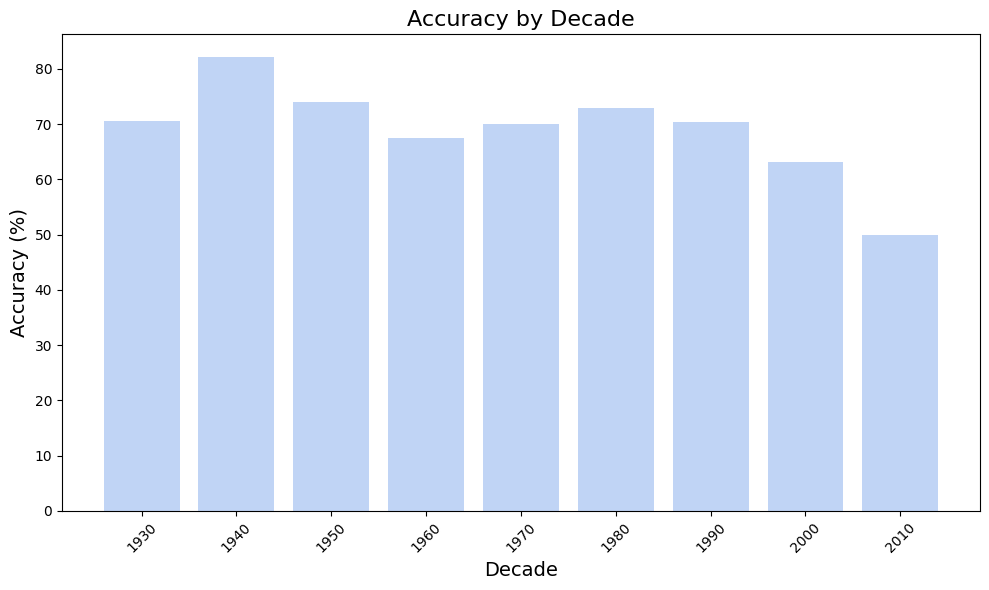

In [170]:
# Ensure 'movie_year' is numeric
predictions_and_movie_meta['movie_year'] = pd.to_numeric(predictions_and_movie_meta['movie_year'], errors='coerce')

# Create a new column for the decade (round down to nearest 10)
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Calculate accuracy per decade
predictions_and_movie_meta['is_correct'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']
accuracy_per_decade = predictions_and_movie_meta.groupby('decade')['is_correct'].mean()

# Convert the result into a DataFrame for better display
accuracy_per_decade_df = pd.DataFrame(accuracy_per_decade).reset_index()
accuracy_per_decade_df.columns = ['Decade', 'Accuracy']
accuracy_per_decade_df['Accuracy'] = accuracy_per_decade_df['Accuracy'] * 100  # Convert to percentage

# Print the accuracy table
print("Accuracy per Decade:")
print(accuracy_per_decade_df.to_string(index=False))  # Plain table display

############# PLOTTING ACCURACY #############
plt.figure(figsize=(10, 6))
plt.bar(
    accuracy_per_decade_df['Decade'], 
    accuracy_per_decade_df['Accuracy'], 
    color=plt.cm.coolwarm_r(0.6), 
    width=8
)

# Customize the plot
plt.title("Accuracy by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(accuracy_per_decade_df['Decade'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Gender ratio for the test data through the decades

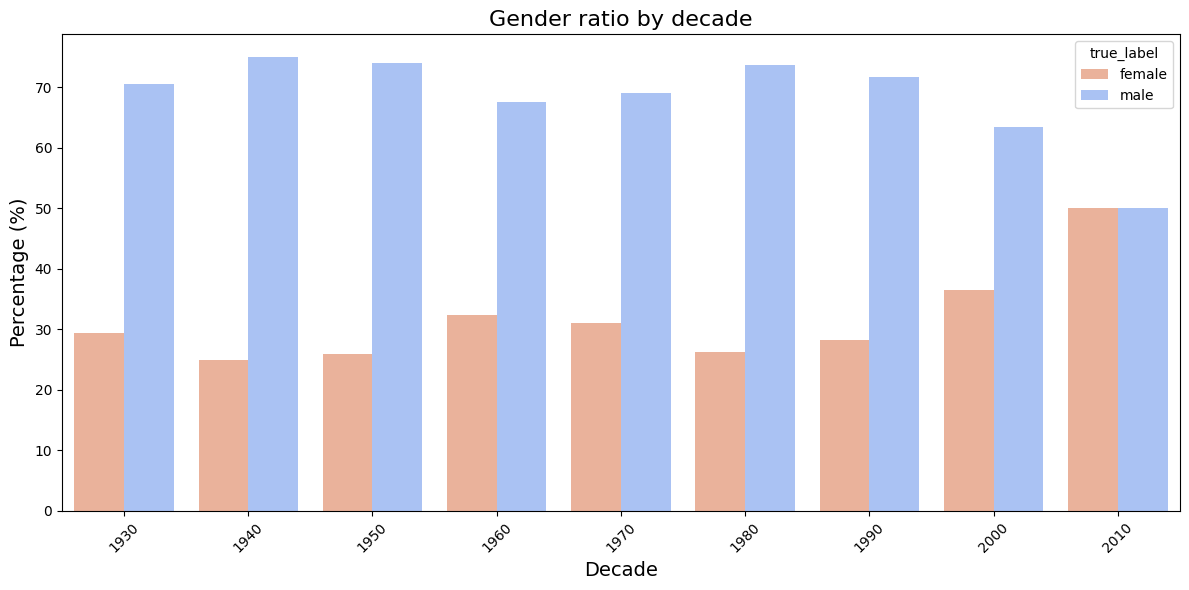

In [171]:
# Convert years to decades
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Group by decade and true_label which female or male
decade_counts = predictions_and_movie_meta.groupby(['decade', 'true_label']).size().reset_index(name='count')

# Calculate total count per decade for percentage calculation
total_per_decade = decade_counts.groupby('decade')['count'].transform('sum')

# Calculate the percentage
decade_counts['percentage'] = (decade_counts['count'] / total_per_decade) * 100

############# PLOTTING #############
# Define the colors
female_color = plt.cm.coolwarm_r(0.3)  # Color for female
male_color = plt.cm.coolwarm_r(0.7)  # Color for male

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_counts,
    x='decade',
    y='percentage',
    hue='true_label',
    palette={'female': female_color, 'male': male_color})  # set colors for True/False

# Customize the plot
plt.title("Gender ratio by decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Undersampling the dominant class to achieve equal train splits

Create train/test split

In [172]:
# Convert string representations of lists to actual lists
genderize_emotions_by_character['basic_emotions_vector'] = genderize_emotions_by_character['basic_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "basic_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions_by_character['basic_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions_by_character['gender']  # Target label

# Split the data into training and test sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)

# Apply RandomUnderSampler to under-sample the majority class in the training data
under_sampler = RandomUnderSampler(random_state=76)
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_feats, y_train)

# Check the class distribution after under-sampling are correct
print(f"Class distribution in train data after under-sampling:\n{y_train_balanced.value_counts()}")
print(f"Class distribution in test data after under-sampling:\n{y_test.value_counts()}")

Class distribution in train data after under-sampling:
gender
female    1429
male      1429
Name: count, dtype: int64
Class distribution in test data after under-sampling:
gender
male      829
female    357
Name: count, dtype: int64


Apply the classifier

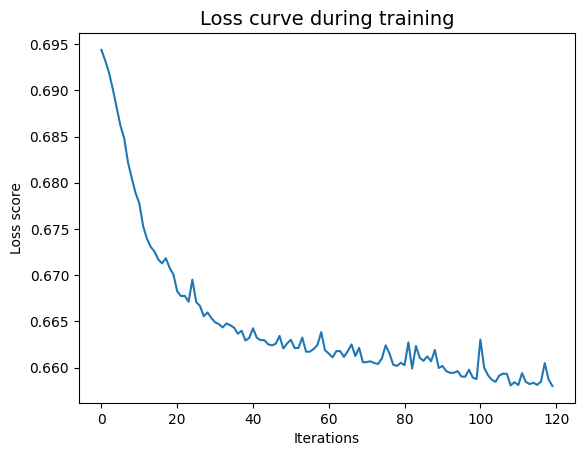

Classification report for the NN basic emotions (under sampling)
              precision    recall  f1-score   support

      female       0.37      0.55      0.44       357
        male       0.76      0.60      0.67       829

    accuracy                           0.59      1186
   macro avg       0.57      0.58      0.56      1186
weighted avg       0.64      0.59      0.60      1186



['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_basic_emotions_undersampling.joblib']

<Figure size 640x480 with 0 Axes>

In [173]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(100, 50),
    max_iter=3000,
    learning_rate_init=0.001,
    random_state=76)

# Train the classifier
classifier.fit(X_train_balanced, y_train_balanced) 

# Make predictions on the test set
y_pred = classifier.predict(X_test_feats) 

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_basic_emotions_undersampling.png")

# Generate and save the classification report
classification_metrics = metrics.classification_report(y_test, y_pred)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_basic_emotions_undersampling.txt", "w") as f:
    f.write(classification_metrics)

# Print the report
print("Classification report for the NN basic emotions (under sampling)")
print(classification_metrics)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_basic_emotions_undersampling.joblib")

Get the predictions into a df and merge it with the meta data

In [174]:
# Extract the indices of the test set from the split
test_indices = y_test.index 

# Create a DataFrame with the characters, true labels, and predictions
character_predictions_basic_undersampling = pd.DataFrame({
    'characterID': genderize_emotions_by_character.loc[test_indices, 'characterID'],
    'true_label': y_test.values,
    'predicted_label': y_pred})

# Check that everything looks godd
print(character_predictions_basic_undersampling.head())

     characterID true_label predicted_label
3383       u5718       male          female
4241       u6845       male            male
3310       u5606       male            male
4866       u7674       male          female
1096       u2548       male          female


In [175]:
# We want to merge the df with "movie_meta"
predictions_and_movie_meta = pd.merge(
    movie_meta,  # keep all the columns from movie_meta_labels 
    character_predictions_basic_undersampling[['characterID', 'true_label', 'predicted_label']],  # Select 'characterID' and 'true_label' and 'predicted_label' from movie_characters_original
    on='characterID',  # Merge on 'characterID'
    how='inner'  # We only want to keep the rows with matching characterID
)

# Adding a column indicating whether the prediction was correct
predictions_and_movie_meta['correct_prediction'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']

# Check that everything looks good
print(f'Number of rows: {len(predictions_and_movie_meta)}') 
print(predictions_and_movie_meta.head())

# Print the number of instances for unique values in 'predicted_label'
print("\nNumber of instances for unique values in 'predicted_label':")
print(predictions_and_movie_meta['predicted_label'].value_counts())

Number of rows: 1186
  characterID character_name  movie_year gender genderize_gender true_label  \
0          u2        Cameron        1999      m                m       male   
1          u4           Joey        1999      m                m       male   
2          u8     Miss Perky        1999      ?                f     female   
3         u12         Alonso        1992      ?                m       male   
4         u14        Beatrix        1992      ?                f     female   

  predicted_label  correct_prediction  
0            male                True  
1            male                True  
2            male               False  
3            male                True  
4            male               False  

Number of instances for unique values in 'predicted_label':
predicted_label
male      662
female    524
Name: count, dtype: int64


Investigating predictions per decade

Accuracy per Decade:
 Decade   Accuracy
   1930  67.647059
   1940  67.857143
   1950  77.777778
   1960  54.054054
   1970  66.000000
   1980  58.371041
   1990  57.667387
   2000  54.744526
   2010 100.000000


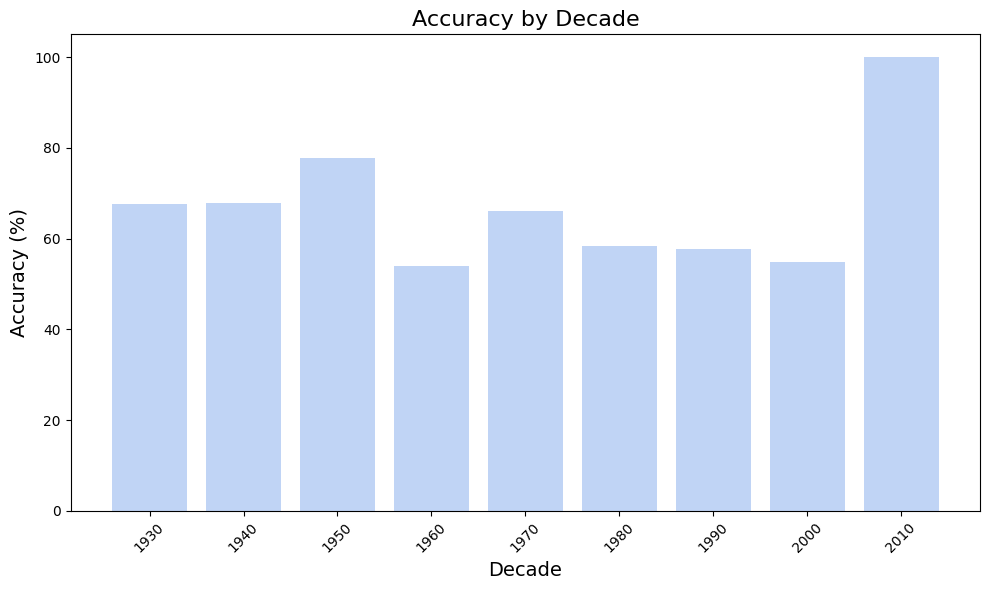

In [176]:
# Ensure 'movie_year' is numeric
predictions_and_movie_meta['movie_year'] = pd.to_numeric(predictions_and_movie_meta['movie_year'], errors='coerce')

# Create a new column for the decade (round down to nearest 10)
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Calculate accuracy per decade
predictions_and_movie_meta['is_correct'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']
accuracy_per_decade = predictions_and_movie_meta.groupby('decade')['is_correct'].mean()

# Convert the result into a DataFrame for better display
accuracy_per_decade_df = pd.DataFrame(accuracy_per_decade).reset_index()
accuracy_per_decade_df.columns = ['Decade', 'Accuracy']
accuracy_per_decade_df['Accuracy'] = accuracy_per_decade_df['Accuracy'] * 100  # Convert to percentage

# Print the accuracy table
print("Accuracy per Decade:")
print(accuracy_per_decade_df.to_string(index=False))  # Plain table display

############# PLOTTING ACCURACY #############
plt.figure(figsize=(10, 6))
plt.bar(
    accuracy_per_decade_df['Decade'], 
    accuracy_per_decade_df['Accuracy'], 
    color=plt.cm.coolwarm_r(0.6), 
    width=8
)

# Customize the plot
plt.title("Accuracy by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(accuracy_per_decade_df['Decade'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Gender ratio for the test data through the decades

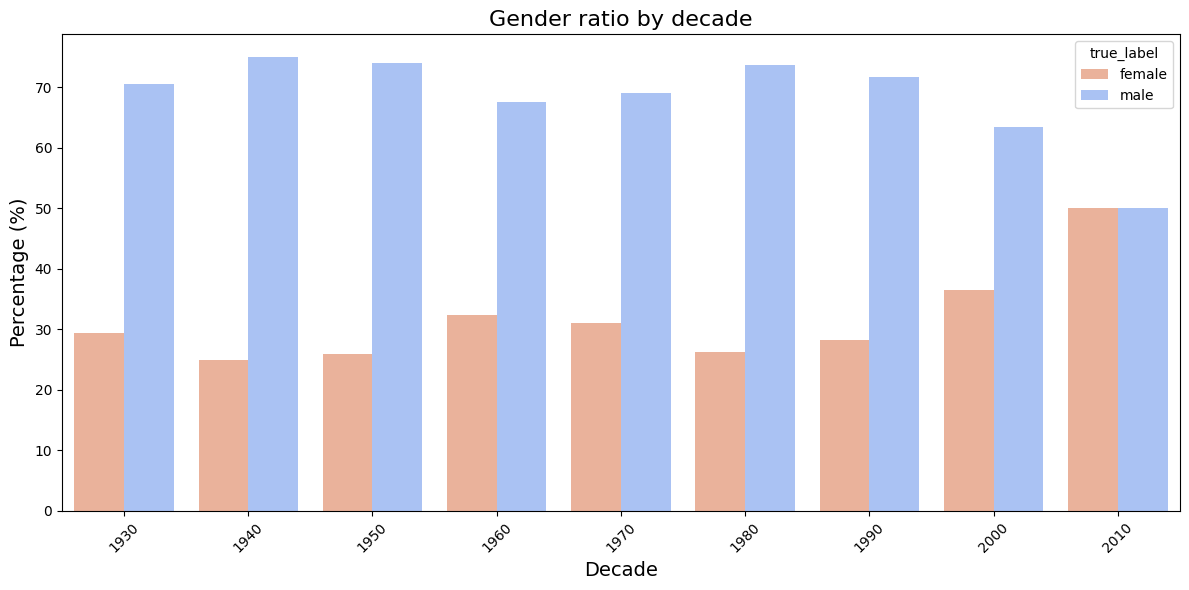

In [177]:
# Convert years to decades
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Group by decade and true_label which female or male
decade_counts = predictions_and_movie_meta.groupby(['decade', 'true_label']).size().reset_index(name='count')

# Calculate total count per decade for percentage calculation
total_per_decade = decade_counts.groupby('decade')['count'].transform('sum')

# Calculate the percentage
decade_counts['percentage'] = (decade_counts['count'] / total_per_decade) * 100

############# PLOTTING #############
# Define the colors
female_color = plt.cm.coolwarm_r(0.3)  # Color for female
male_color = plt.cm.coolwarm_r(0.7)  # Color for male

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_counts,
    x='decade',
    y='percentage',
    hue='true_label',
    palette={'female': female_color, 'male': male_color})  # set colors for True/False

# Customize the plot
plt.title("Gender ratio by decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### For all emotions

Make a test/train split - no resampling

In [178]:
# Convert string representations of lists to actual lists
genderize_emotions['all_emotions_vector'] = genderize_emotions['all_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "all_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions['all_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions['gender']  # Target label

# Split into training and testing sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)

print(f"Training set size: {len(X_train_feats)}")
print(f"Testing set size: {len(X_test_feats)}")

Training set size: 222151
Testing set size: 55538


Apply the classifier

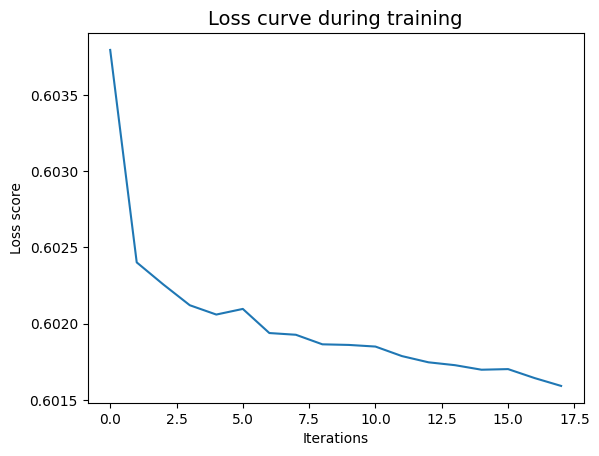

/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report for the NN all emotions
              precision    recall  f1-score   support

      female       0.00      0.00      0.00     16216
        male       0.71      1.00      0.83     39322

    accuracy                           0.71     55538
   macro avg       0.35      0.50      0.41     55538
weighted avg       0.50      0.71      0.59     55538



/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_all_emotions.joblib']

<Figure size 640x480 with 0 Axes>

In [179]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(64, 32),
    max_iter=2000,
    learning_rate_init=0.001,
    random_state=76
)

# Train the classifier
classifier.fit(X_train_feats, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_feats)

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_all_emotions.png")

# Generate and save the classification report
classification_metrics = metrics.classification_report(y_test, y_pred)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_all_emotions.txt", "w") as f:
    f.write(classification_metrics)

# Print the report
print("Classification report for the NN all emotions")
print(classification_metrics)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_all_emotions.joblib")

#### SMOTE (Synthetic Minority Over-sampling Technique)

Make a test/train split - resampled with SMOTE 

In [180]:
# Convert string representations of lists to actual lists
genderize_emotions_by_character['all_emotions_vector'] = genderize_emotions_by_character['all_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "all_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions_by_character['all_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions_by_character['gender']  # Target label

# Split the data into training and test sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=76)
X_train_feats_resampled, y_train_resampled = smote.fit_resample(X_train_feats, y_train)

# Check the class distribution in the resampled data
print(f"Class distribution after SMOTE: {y_train_resampled.value_counts()}")

Class distribution after SMOTE: gender
male      3314
female    3314
Name: count, dtype: int64


Applying the classifier (resampled: SMOTE)

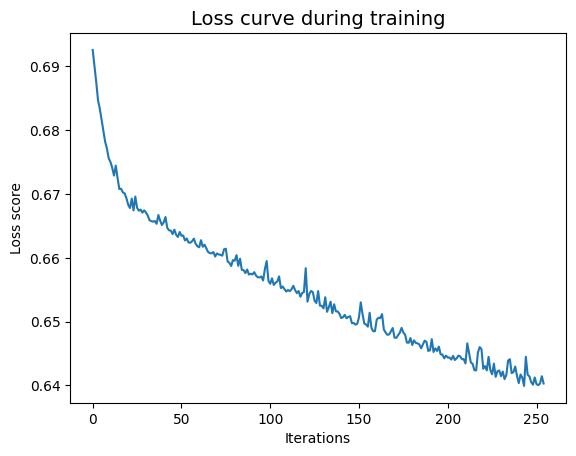

Classification report NN all emotions (SMOTE):
              precision    recall  f1-score   support

      female       0.41      0.56      0.47       357
        male       0.78      0.65      0.71       829

    accuracy                           0.63      1186
   macro avg       0.59      0.61      0.59      1186
weighted avg       0.67      0.63      0.64      1186



['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_all_emotions_SMOTE.joblib']

<Figure size 640x480 with 0 Axes>

In [181]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(64, 32),
    max_iter=1000,
    learning_rate_init=0.001,
    random_state=76)

# Train the classifier with the undersampled data
classifier.fit(X_train_feats_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = classifier.predict(X_test_feats)  # Use the original test set (no undersampling on the test set)

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_all_emotions_SMOTE.png")

# Generate and save the classification report
classification_metrics = metrics.classification_report(y_test, y_pred)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_all_emotions_SMOTE.txt", "w") as f:
    f.write(classification_metrics)

# Print the report
print("Classification report NN all emotions (SMOTE):")
print(classification_metrics)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_all_emotions_SMOTE.joblib")

Get the predictions into a df and merge it with the meta data

In [182]:
# Extract the indices of the test set from the split
test_indices = y_test.index 

# Create a DataFrame with the characters, true labels, and predictions
character_predictions_14_SMOTE = pd.DataFrame({
    'characterID': genderize_emotions_by_character.loc[test_indices, 'characterID'],
    'true_label': y_test.values,
    'predicted_label': y_pred})
    
# Check that everything looks godd
print(character_predictions_14_SMOTE.head())

     characterID true_label predicted_label
3383       u5718       male            male
4241       u6845       male            male
3310       u5606       male            male
4866       u7674       male            male
1096       u2548       male          female


In [183]:
# We want to merge the df with "movie_meta"
predictions_and_movie_meta = pd.merge(
    movie_meta,  # keep all the columns from movie_meta_labels 
    character_predictions_14_SMOTE[['characterID', 'true_label', 'predicted_label']],  # Select 'characterID' and 'true_label' and 'predicted_label' from movie_characters_original
    on='characterID',  # Merge on 'characterID'
    how='inner'  # We only want to keep the rows with matching characterID
)

# Adding a column indicating whether the prediction was correct
predictions_and_movie_meta['correct_prediction'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']

# Check that everything looks good
print(f'Number of rows: {len(predictions_and_movie_meta)}') 
print(predictions_and_movie_meta.head())

# Print the number of instances for unique values in 'predicted_label'
print("\nNumber of instances for unique values in 'predicted_label':")
print(predictions_and_movie_meta['predicted_label'].value_counts())

Number of rows: 1186
  characterID character_name  movie_year gender genderize_gender true_label  \
0          u2        Cameron        1999      m                m       male   
1          u4           Joey        1999      m                m       male   
2          u8     Miss Perky        1999      ?                f     female   
3         u12         Alonso        1992      ?                m       male   
4         u14        Beatrix        1992      ?                f     female   

  predicted_label  correct_prediction  
0            male                True  
1            male                True  
2          female                True  
3          female               False  
4            male               False  

Number of instances for unique values in 'predicted_label':
predicted_label
male      699
female    487
Name: count, dtype: int64


Investigating predictions per decade

Accuracy per Decade:
 Decade   Accuracy
   1930  73.529412
   1940  67.857143
   1950  77.777778
   1960  59.459459
   1970  66.000000
   1980  65.158371
   1990  59.611231
   2000  60.948905
   2010 100.000000


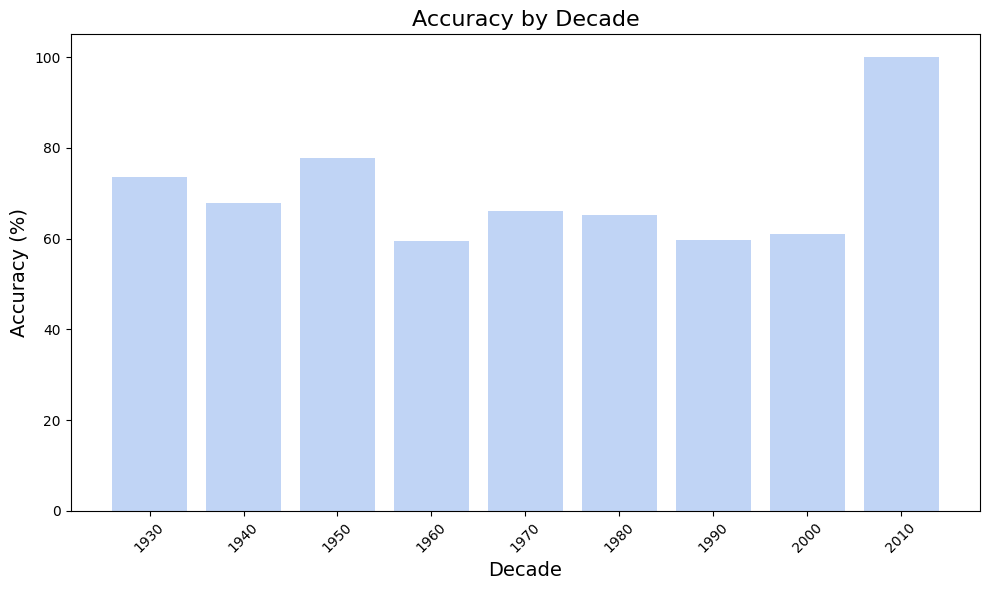

In [184]:
# Ensure 'movie_year' is numeric
predictions_and_movie_meta['movie_year'] = pd.to_numeric(predictions_and_movie_meta['movie_year'], errors='coerce')

# Create a new column for the decade (round down to nearest 10)
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Calculate accuracy per decade
predictions_and_movie_meta['is_correct'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']
accuracy_per_decade = predictions_and_movie_meta.groupby('decade')['is_correct'].mean()

# Convert the result into a DataFrame for better display
accuracy_per_decade_df = pd.DataFrame(accuracy_per_decade).reset_index()
accuracy_per_decade_df.columns = ['Decade', 'Accuracy']
accuracy_per_decade_df['Accuracy'] = accuracy_per_decade_df['Accuracy'] * 100  # Convert to percentage

# Print the accuracy table
print("Accuracy per Decade:")
print(accuracy_per_decade_df.to_string(index=False))  # Plain table display

############# PLOTTING ACCURACY #############
plt.figure(figsize=(10, 6))
plt.bar(
    accuracy_per_decade_df['Decade'], 
    accuracy_per_decade_df['Accuracy'], 
    color=plt.cm.coolwarm_r(0.6), 
    width=8
)

# Customize the plot
plt.title("Accuracy by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(accuracy_per_decade_df['Decade'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Gender ratio for the test data through the decades

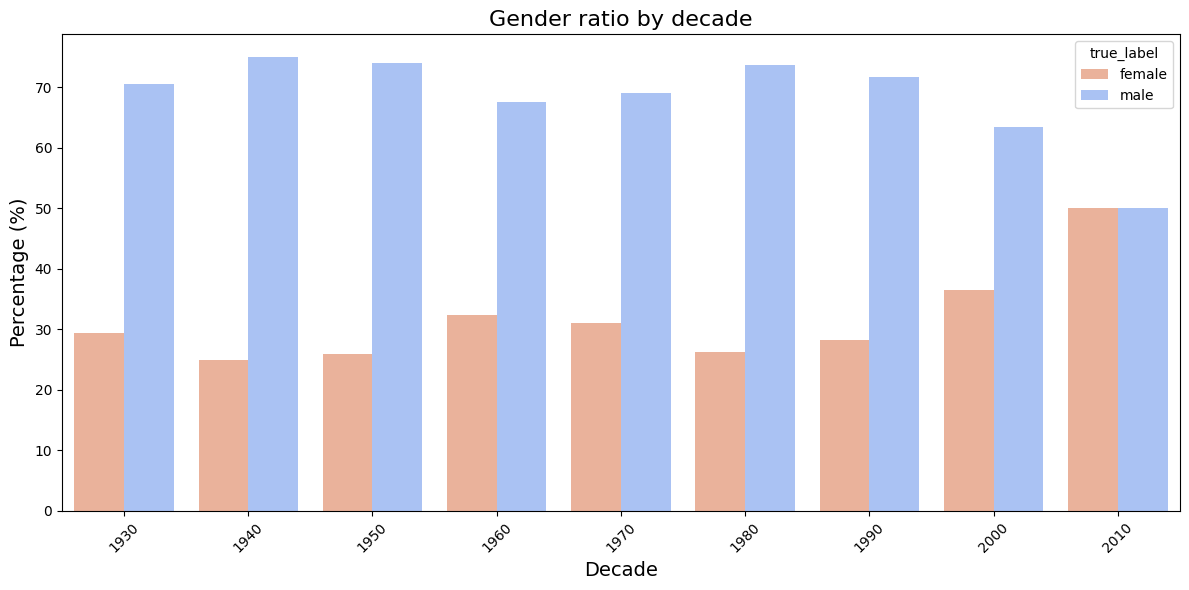

In [185]:
# Convert years to decades
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Group by decade and true_label which female or male
decade_counts = predictions_and_movie_meta.groupby(['decade', 'true_label']).size().reset_index(name='count')

# Calculate total count per decade for percentage calculation
total_per_decade = decade_counts.groupby('decade')['count'].transform('sum')

# Calculate the percentage
decade_counts['percentage'] = (decade_counts['count'] / total_per_decade) * 100

############# PLOTTING #############
# Define the colors
female_color = plt.cm.coolwarm_r(0.3)  # Color for female
male_color = plt.cm.coolwarm_r(0.7)  # Color for male

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_counts,
    x='decade',
    y='percentage',
    hue='true_label',
    palette={'female': female_color, 'male': male_color})  # set colors for True/False

# Customize the plot
plt.title("Gender ratio by decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### Undersampling the dominant class to achieve equal train and test splits

Create train/test split

In [186]:
# Convert string representations of lists to actual lists
genderize_emotions_by_character['all_emotions_vector'] = genderize_emotions_by_character['all_emotions_vector'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure "all_emotions_vector" is properly expanded into a numpy array
X = np.array(genderize_emotions_by_character['all_emotions_vector'].tolist())  # Convert vector column to numpy array
y = genderize_emotions_by_character['gender']  # Target label

# Split the data into training and test sets
X_train_feats, X_test_feats, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)

# Apply RandomUnderSampler to under-sample the majority class in the training data
under_sampler = RandomUnderSampler(random_state=76)
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_feats, y_train)

# Check the class distribution after under-sampling are correct
print(f"Class distribution in train data after under-sampling:\n{y_train_balanced.value_counts()}")
print(f"Class distribution in test data after under-sampling:\n{y_test.value_counts()}")

Class distribution in train data after under-sampling:
gender
female    1429
male      1429
Name: count, dtype: int64
Class distribution in test data after under-sampling:
gender
male      829
female    357
Name: count, dtype: int64


Apply the classifier

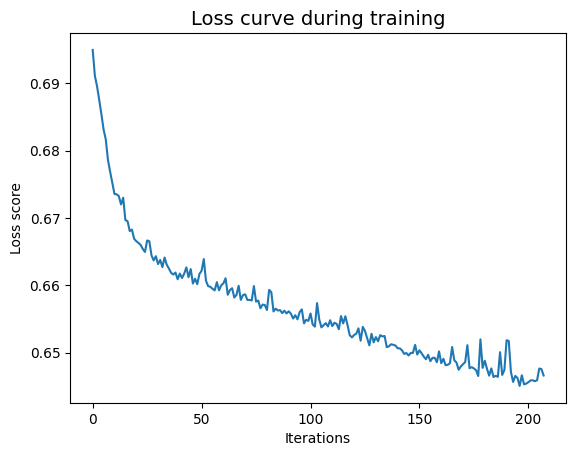

Classification report for the NN all emotions (under sampling)
              precision    recall  f1-score   support

      female       0.36      0.72      0.48       357
        male       0.79      0.45      0.57       829

    accuracy                           0.53      1186
   macro avg       0.57      0.58      0.53      1186
weighted avg       0.66      0.53      0.55      1186



['/work/VNV/Module 4 - Clustering and prediction/prediction/models/NN_classifier_all_emotions_undersampling.joblib']

<Figure size 640x480 with 0 Axes>

In [187]:
# Define the classifier
classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(100, 50),
    max_iter=3000,
    learning_rate_init=0.001,
    random_state=76)

# Train the classifier
classifier.fit(X_train_balanced, y_train_balanced) 

# Make predictions on the test set
y_pred = classifier.predict(X_test_feats) 

# Plot the loss curve during training
plt.plot(classifier.loss_curve_)
plt.title("Loss curve during training", fontsize=14)
plt.xlabel("Iterations")
plt.ylabel("Loss score")
plt.show()

# Save the loss curve plot
plt.savefig("/work/VNV/Module 4 - Prediction/prediction/output/NN_all_emotions_undersampling.png")

# Generate and save the classification report
classification_metrics = metrics.classification_report(y_test, y_pred)
with open("/work/VNV/Module 4 - Prediction/prediction/output/Classification_report_NN_all_emotions_undersampling.txt", "w") as f:
    f.write(classification_metrics)

# Print the report
print("Classification report for the NN all emotions (under sampling)")
print(classification_metrics)

# Save the trained classifier
dump(classifier, "/work/VNV/Module 4 - Prediction/prediction/models/NN_classifier_all_emotions_undersampling.joblib")

Get the predictions into a df and merge it with the meta data

In [188]:
# Extract the indices of the test set from the split
test_indices = y_test.index 

# Create a DataFrame with the characters, true labels, and predictions
character_predictions_14_undersampling = pd.DataFrame({
    'characterID': genderize_emotions_by_character.loc[test_indices, 'characterID'],
    'true_label': y_test.values,
    'predicted_label': y_pred})

# Check that everything looks godd
print(character_predictions_14_undersampling.head())

     characterID true_label predicted_label
3383       u5718       male          female
4241       u6845       male            male
3310       u5606       male            male
4866       u7674       male          female
1096       u2548       male          female


In [189]:
# We want to merge the df with "movie_meta"
predictions_and_movie_meta = pd.merge(
    movie_meta,  # keep all the columns from movie_meta_labels 
    character_predictions_14_undersampling[['characterID', 'true_label', 'predicted_label']],  # Select 'characterID' and 'true_label' and 'predicted_label' from movie_characters_original
    on='characterID',  # Merge on 'characterID'
    how='inner'  # We only want to keep the rows with matching characterID
)

# Adding a column indicating whether the prediction was correct
predictions_and_movie_meta['correct_prediction'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']

# Check that everything looks good
print(f'Number of rows: {len(predictions_and_movie_meta)}')
print(predictions_and_movie_meta.head())

# Print the number of instances for unique values in 'predicted_label'
print("\nNumber of instances for unique values in 'predicted_label':")
print(predictions_and_movie_meta['predicted_label'].value_counts())

Number of rows: 1186
  characterID character_name  movie_year gender genderize_gender true_label  \
0          u2        Cameron        1999      m                m       male   
1          u4           Joey        1999      m                m       male   
2          u8     Miss Perky        1999      ?                f     female   
3         u12         Alonso        1992      ?                m       male   
4         u14        Beatrix        1992      ?                f     female   

  predicted_label  correct_prediction  
0            male                True  
1            male                True  
2          female                True  
3            male                True  
4            male               False  

Number of instances for unique values in 'predicted_label':
predicted_label
female    710
male      476
Name: count, dtype: int64


Investigating predictions per decade

Accuracy per Decade:
 Decade   Accuracy
   1930  64.705882
   1940  64.285714
   1950  66.666667
   1960  48.648649
   1970  59.000000
   1980  51.131222
   1990  51.187905
   2000  52.554745
   2010 100.000000


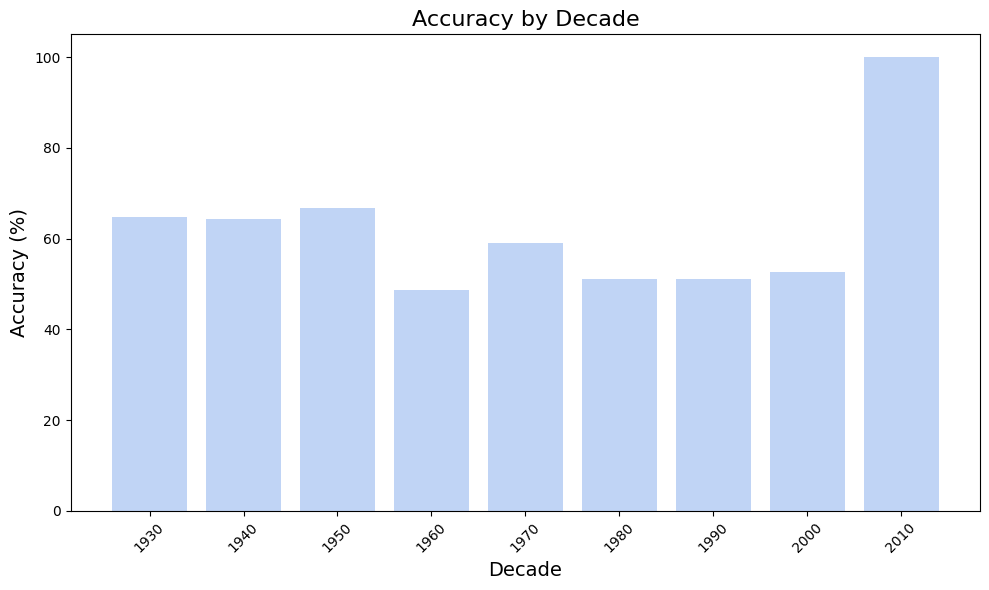

In [190]:
# Ensure 'movie_year' is numeric
predictions_and_movie_meta['movie_year'] = pd.to_numeric(predictions_and_movie_meta['movie_year'], errors='coerce')

# Create a new column for the decade (round down to nearest 10)
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Calculate accuracy per decade
predictions_and_movie_meta['is_correct'] = predictions_and_movie_meta['true_label'] == predictions_and_movie_meta['predicted_label']
accuracy_per_decade = predictions_and_movie_meta.groupby('decade')['is_correct'].mean()

# Convert the result into a DataFrame for better display
accuracy_per_decade_df = pd.DataFrame(accuracy_per_decade).reset_index()
accuracy_per_decade_df.columns = ['Decade', 'Accuracy']
accuracy_per_decade_df['Accuracy'] = accuracy_per_decade_df['Accuracy'] * 100  # Convert to percentage

# Print the accuracy table
print("Accuracy per Decade:")
print(accuracy_per_decade_df.to_string(index=False))  # Plain table display

############# PLOTTING ACCURACY #############
plt.figure(figsize=(10, 6))
plt.bar(
    accuracy_per_decade_df['Decade'], 
    accuracy_per_decade_df['Accuracy'], 
    color=plt.cm.coolwarm_r(0.6), 
    width=8
)

# Customize the plot
plt.title("Accuracy by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(accuracy_per_decade_df['Decade'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Gender ratio for the test data through the decades

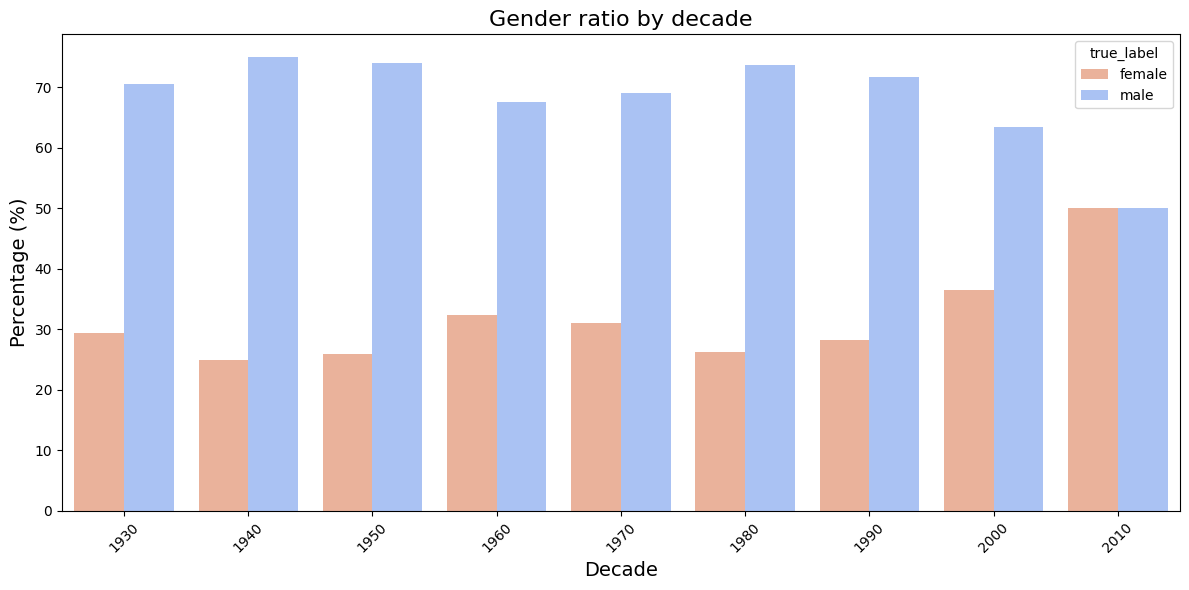

In [191]:
# Convert years to decades
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Group by decade and true_label which female or male
decade_counts = predictions_and_movie_meta.groupby(['decade', 'true_label']).size().reset_index(name='count')

# Calculate total count per decade for percentage calculation
total_per_decade = decade_counts.groupby('decade')['count'].transform('sum')

# Calculate the percentage
decade_counts['percentage'] = (decade_counts['count'] / total_per_decade) * 100

############# PLOTTING #############
# Define the colors
female_color = plt.cm.coolwarm_r(0.3)  # Color for female
male_color = plt.cm.coolwarm_r(0.7)  # Color for male

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_counts,
    x='decade',
    y='percentage',
    hue='true_label',
    palette={'female': female_color, 'male': male_color})  # set colors for True/False

# Customize the plot
plt.title("Gender ratio by decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Instances of unique labels per decade:
Decade 1930: {'female': 10, 'male': 24}
Decade 1940: {'female': 7, 'male': 21}
Decade 1950: {'female': 7, 'male': 20}
Decade 1960: {'female': 12, 'male': 25}
Decade 1970: {'female': 31, 'male': 69}
Decade 1980: {'female': 58, 'male': 163}
Decade 1990: {'female': 131, 'male': 332}
Decade 2000: {'female': 100, 'male': 174}
Decade 2010: {'female': 1, 'male': 1}


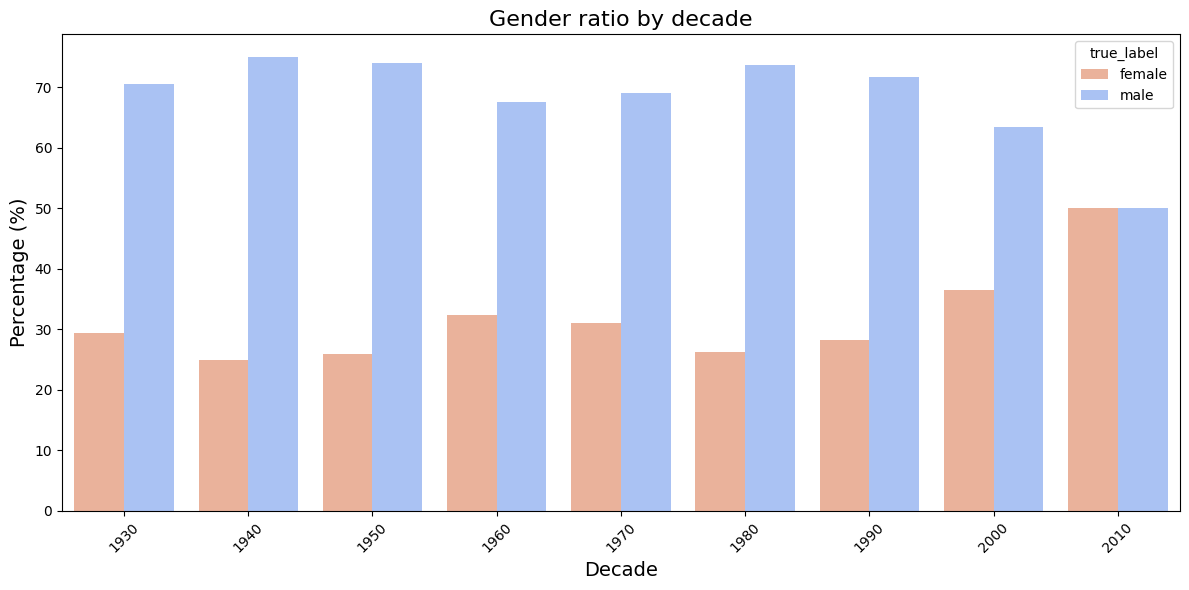

In [194]:
# Convert years to decades
predictions_and_movie_meta['decade'] = (predictions_and_movie_meta['movie_year'] // 10) * 10

# Group by decade and true_label (female or male)
decade_counts = predictions_and_movie_meta.groupby(['decade', 'true_label']).size().reset_index(name='count')

# Calculate total count per decade for percentage calculation
total_per_decade = decade_counts.groupby('decade')['count'].transform('sum')

# Calculate the percentage
decade_counts['percentage'] = (decade_counts['count'] / total_per_decade) * 100

# Generate a table with counts for unique labels per decade
# Convert the grouped data into a dictionary for a tabular representation
table_data = {}
for decade in sorted(predictions_and_movie_meta['decade'].unique()):
    decade_data = decade_counts[decade_counts['decade'] == decade]
    table_data[decade] = {
        row['true_label']: row['count'] for _, row in decade_data.iterrows()
    }

# Format the table to include counts per decade
print("Instances of unique labels per decade:")
for decade, label_data in sorted(table_data.items()):
    print(f"Decade {decade}: {label_data}")

############# PLOTTING #############
# Define the colors
female_color = plt.cm.coolwarm_r(0.3)  # Color for female
male_color = plt.cm.coolwarm_r(0.7)  # Color for male

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_counts,
    x='decade',
    y='percentage',
    hue='true_label',
    palette={'female': female_color, 'male': male_color})  # set colors for True/False

# Customize the plot
plt.title("Gender ratio by decade", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


## Simulating to find our chance level

If choices are made randomly

In [192]:
# Set the seed for reproducibility
random.seed(76)
np.random.seed(76)

prob = 0.7  # proportion of majority class (males)
n_samples = 1000  # number of cases

# simulate true label 
y_true = random.choices([0, 1], weights=[1 - prob, prob], k=n_samples)

# randomly guess 0 or 1
y_pred_random = np.random.randint(0, 2, size=n_samples)

f_1_random = (f1_score(y_true, y_pred_random))

# Print the F1 score
print(f"F1 Score when predicting randomly: {f_1_random:.3f}")

F1 Score when predicting randomly: 0.577


If only the majority class is chosen

In [193]:
# Set the seed for reproducibility
random.seed(76)
np.random.seed(76)

# Parameters
prob = 0.7  # Proportion of the majority class (males)
n_samples = 1000  # Number of cases

# Simulate true labels
y_true = random.choices([0, 1], weights=[1 - prob, prob], k=n_samples)

# Predict only the majority class (1 in this case)
y_pred_majority = [1] * n_samples

# Compute F1 score for predictions based on the majority class
f1_majority = f1_score(y_true, y_pred_majority)

# Print the F1 score
print(f"F1 Score when predicting solely the majority class: {f1_majority:.3f}")

F1 Score when predicting solely the majority class: 0.831
